# Лабораторная работа 7. Цифровая обработка изображений.

В этой работе рассматриваются различные виды цифровой обработки изображений.

Цель лабораторной работы:
1. Поиск шаблона на изображении
2. Локальные особенности. Особые точки.


In [ ]:
%reset

In [48]:
import sys
sys.path.append('../')
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

# Изменим стандартный размер графиков matplotlib
WIDTH_SIZE = 15
HEIGHT_SIZE = 10
plt.rcParams["figure.figsize"] = [WIDTH_SIZE, HEIGHT_SIZE]

# 1 Поиск шаблона на изображениий

## 1.1 Сопоставление шаблонов

Сопоставление шаблонов — это метод поиска фрагмента изображения (шаблона) и его местоположения в более крупном изображении. Работа метода основана на перемещении окна (ROI) по входному изображению (как в свертке) и вычислении метрики близости фрагмента изображения, ограниченного окном с шаблоном. Результатом этой работы является новое изображение, где каждый пиксель имеет значение метрики близости фрагмента изображения в текущей окрестности с шаблоном. В OpenCV для этого используется функция cv.matchTemplate().
Когда есть выходное изображение с мерой близости можно использовать функцию cv.minMaxLoc() чтобы найти координаты пикселя с максимальным (минимальным) значением меры близости.
В OpenCV реализовано несколько методов [сравнения](https://docs.opencv.org/3.4/df/dfb/group__imgproc__object.html#ga3a7850640f1fe1f58fe91a2d7583695d). От этого зависит максимальное или минимальное значение необходимо искать.


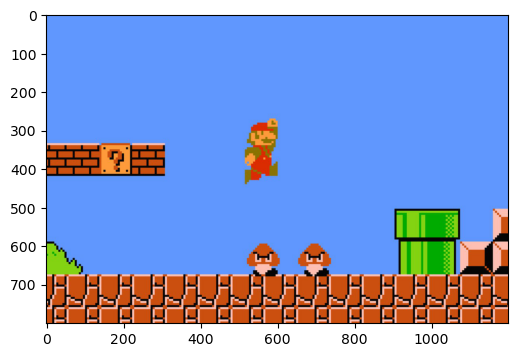

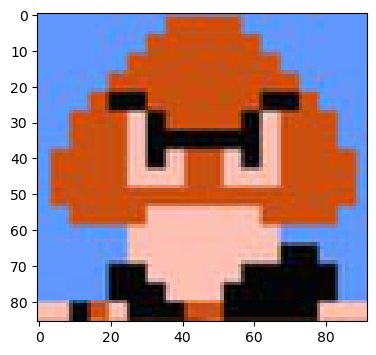

In [22]:
# Загружаем изображение
rgb_img = cv2.imread('../images/mario.jpg') 
plt.figure()
plt.imshow(cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB))
# Преобразуем изображение в оттенки серого 
gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

# Загружаем шаблон  
template = cv2.imread('../images/tmplenemy.jpg')
plt.figure()
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

# Преобразуем в оттенки серого
gray_templ = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)  

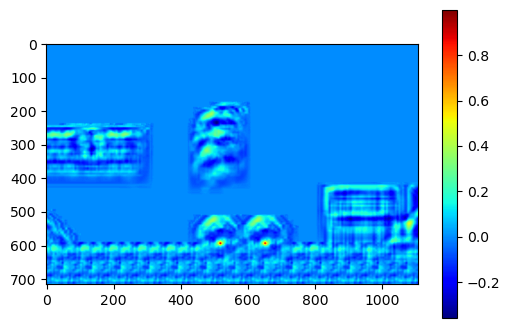

In [23]:
# Считаем размеры шаблона
w, h = template.shape[:-1] 
 
# Вызываем функцию cv2.matchTemplate для вычисления метрики схожести
# в качестве параметров передаем изображение, шаблон и тип вычисляемой метрики
res = cv2.matchTemplate(gray_img,gray_templ,cv2.TM_CCOEFF_NORMED)  

# Возможные варианты метрик:
#    cv2.TM_SQDIFF — сумма квадратов разниц значений пикселей
#    cv2.TM_SQDIFF_NORMED — сумма квадрат разниц цветов, отнормированная в диапазон 0..1.
#    cv2.TM_CCORR — сумма поэлементных произведений шаблона и сегмента картинки
#    cv2.TM_CCORR_NORMED — сумма поэлементных произведений, отнормированное в диапазон -1..1.
#    cv2.TM_CCOEFF — кросс-коррелация изображений без среднего
#    cv2.TM_CCOEFF_NORMED — кросс-корреляция между изображениями без среднего, отнормированная в -1..1 (корреляция Пирсона)
plt.figure()
plt.imshow(res, cmap='jet')
plt.colorbar()

1. Определяем порог для выделения области локализации шаблона на изобажении
Порог зависит от метрики, т.к. значения различных метрик могут различаться
на порядки. Кроме по своей сути некоторые метрики измеряют "похожесть" 
и имеют большие значения для похожих изображений, а другие измеряют "отличие",
и ноборот, большие значения появляются для различающихся изображении

2. Определяем точки изображения в которых метрика превышает порог
Эти точки - центры локализации шаблона
Знак сравнения для метрик, измеряющих "отличия" необходимо заменить на противоположный

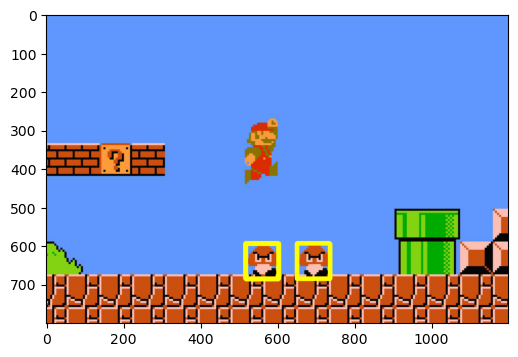

In [24]:
threshold = 0.8
loc = np.where(res >= threshold) 
# Вокруг выделенных максимумов обводим прямоугольники с размерами шаблона
plot_img = rgb_img.copy()
for pt in zip(*loc[::-1]):
    cv2.rectangle(plot_img, pt,(pt[0] + w, pt[1] + h),(0,255,255), 8)  

# Отображаем результат на графике
plt.figure()
plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))


### 1 Если необходимо учесть разность в масштабах шаблона и изображения, строится пирамида изображений, на элементах коотрой выполняется поиск шаблона

Пример построения пирамиды изображений

In [25]:
layer = rgb_img.copy() 
for i in range(3):
# Функция pyrDown() уменьшает масштаб изображения, а  pyrUp() - увеличивает
# По умолчанию масштаб изменяется в два раза
    layer = cv2.pyrDown(layer)
    cv2.imshow("str(i)", layer)
    cv2.waitKey(0)
cv2.destroyAllWindows()





### 2 Для снижения влияния яркости изображения или шаблона на результат, рекомендуется делать поиск не по исходным изображениям, а по выделенным из них границам



(Text(0.5, 1.0, 'Sobel'), ([], []), ([], []))

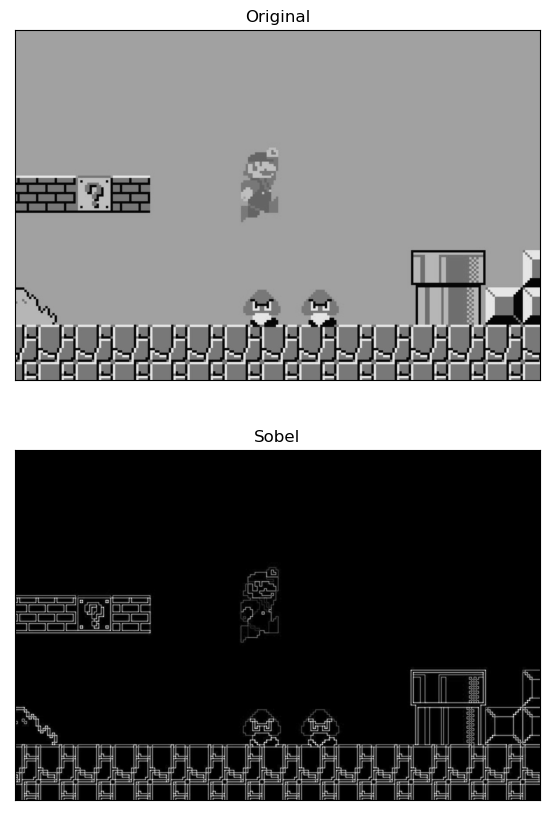

In [29]:
# Границы вычисляем на изображении в оттенках серого
imgG = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

# Для выделения границ используем фильтр Собеля в двух направлениях
x = cv2.Sobel(imgG,cv2.CV_16S,1,0)  
y = cv2.Sobel(imgG,cv2.CV_16S,0,1)  

# берем модуль от результата применения фильтра Собеля
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)  
  
# объединяем "вертикальные" и "горизонтальные" границы в одно изображение
dstI = cv2.addWeighted(absX,0.5,absY,0.5,0)
plt.figure()
plt.subplot(2,1,1),plt.imshow(imgG,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,1,2),plt.imshow(dstI,cmap = 'gray')
plt.title('Sobel'), plt.xticks([]), plt.yticks([])

### Такие же преобразования делаем и с шаблоном, но изменяем яркость шаблона

(Text(0.5, 1.0, 'Sobel'), ([], []), ([], []))

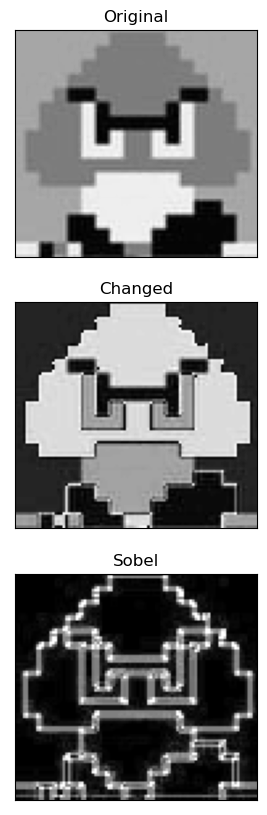

In [30]:
tmpG = 2*cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
x = cv2.Sobel(tmpG,cv2.CV_16S,1,0)  
y = cv2.Sobel(tmpG,cv2.CV_16S,0,1)  
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)  
dstT = cv2.addWeighted(absX,0.5,absY,0.5,0)

plt.subplot(3,1,1),plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2GRAY),cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(3,1,2),plt.imshow(tmpG,cmap = 'gray')
plt.title('Changed'), plt.xticks([]), plt.yticks([])
plt.subplot(3,1,3),plt.imshow(dstT,cmap = 'gray')
plt.title('Sobel'), plt.xticks([]), plt.yticks([])

###  Находим шаблоны по границам

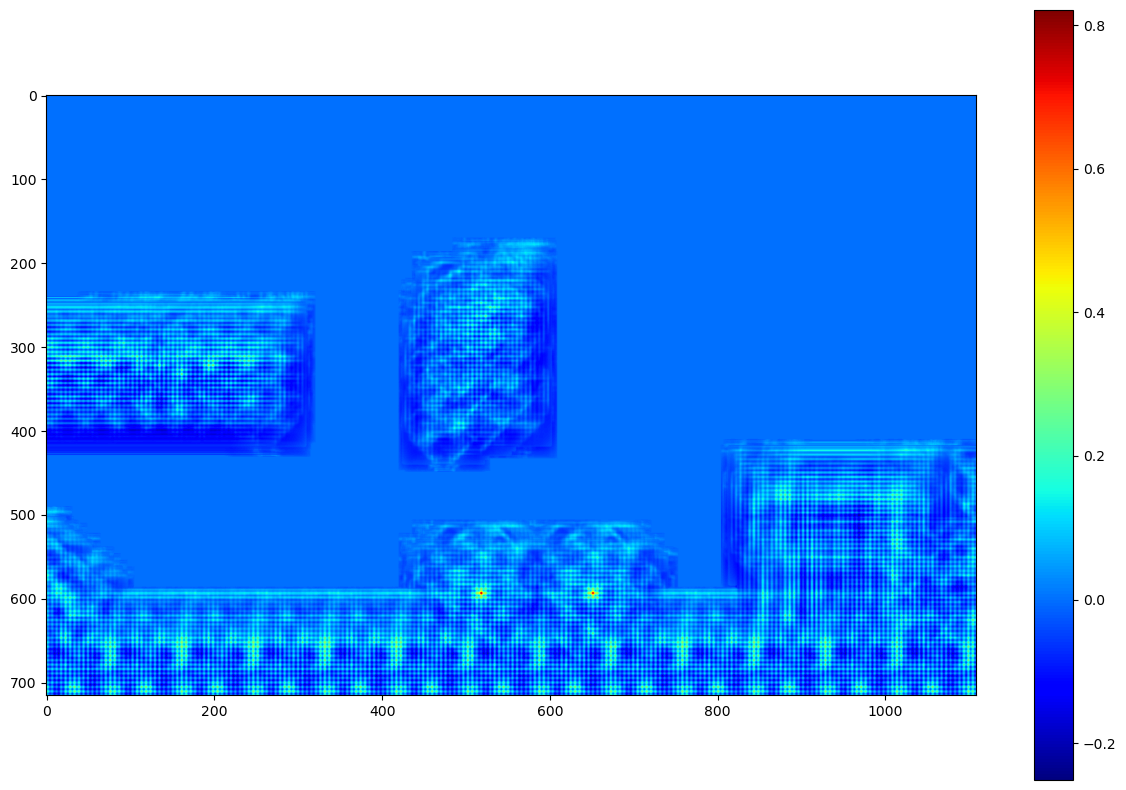

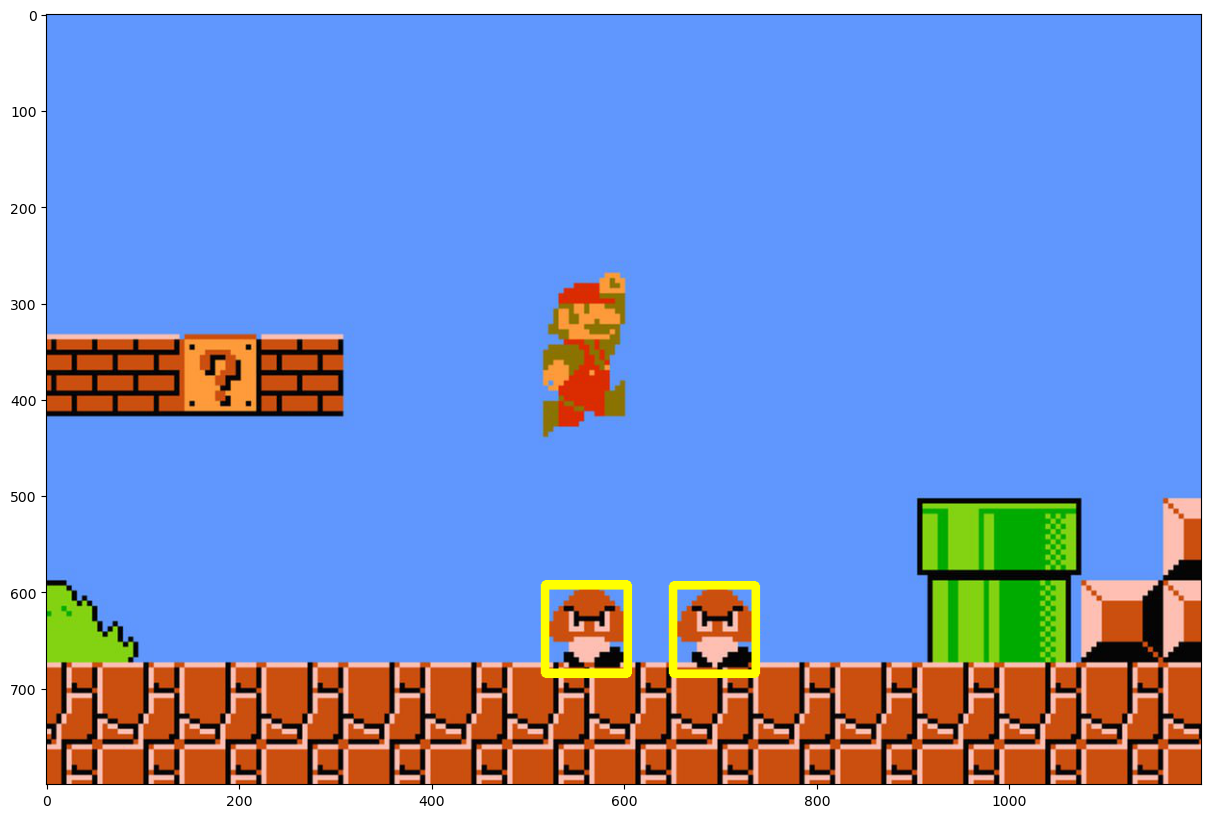

In [35]:
# Считаем размеры шаблона
w, h = tmpG.shape
  
# Вычисляем метрику схожести  
res = cv2.matchTemplate(dstI,dstT,cv2.TM_CCOEFF_NORMED)  
plt.figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE))
plt.imshow(res, cmap='jet')
plt.colorbar()

#  Отбираем максимумы и строим результат на графике
threshold = 0.7
loc = np.where(res >= threshold)  
plot_img = rgb_img.copy()
for pt in zip(*loc[::-1]):
    cv2.rectangle(plot_img, pt,(pt[0] + w, pt[1] + h),(0,255,255), 8)  

plt.figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE))
plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))

### 3 Если предполагается что шаблон может отличаться по яркости, масштабу или ориентации, то рекомендуется использовать методы выделения особых точек, такие как SIFT, SURF, ORB и т.д. Такие методы являются более устойчивыми изменениям шаблона или изображения

(3.508460283279419, 751.6724243164062)
2.0713393688201904
268.0862731933594
0.030542636290192604
2.0713393688201904


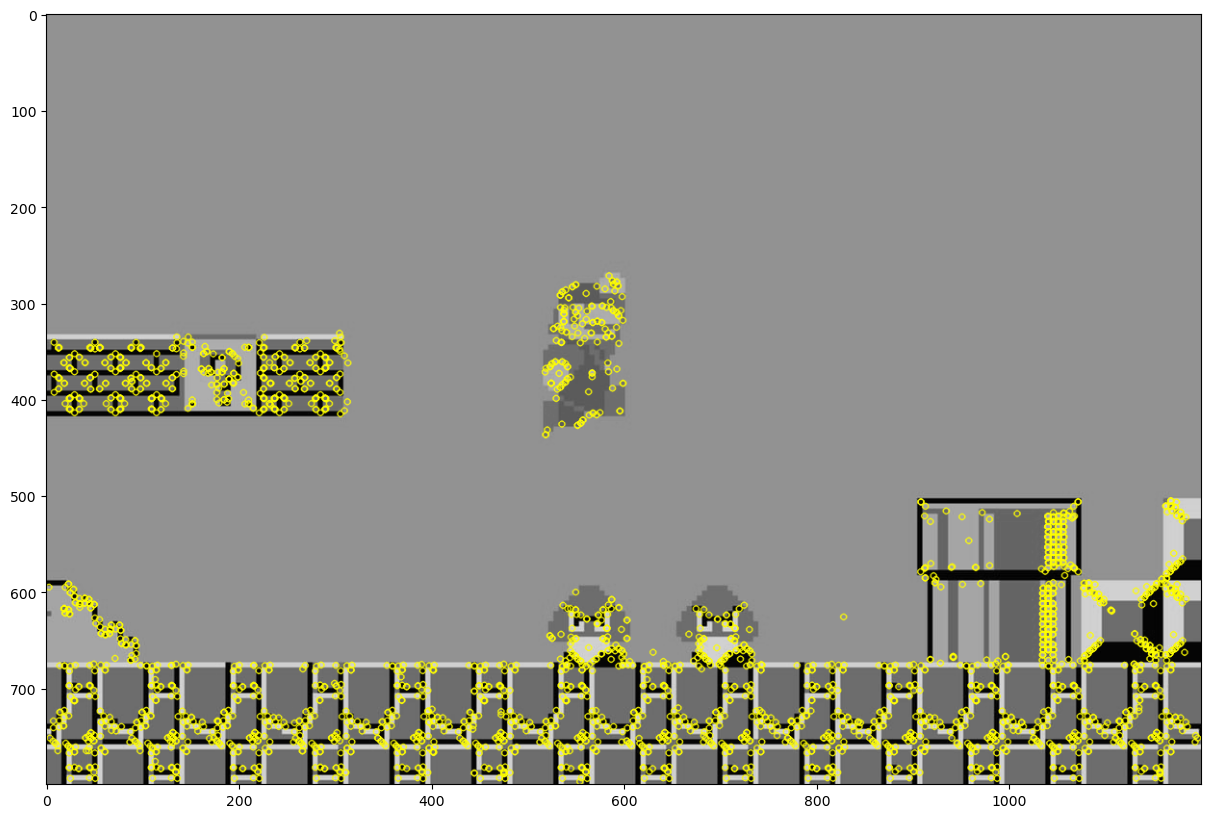

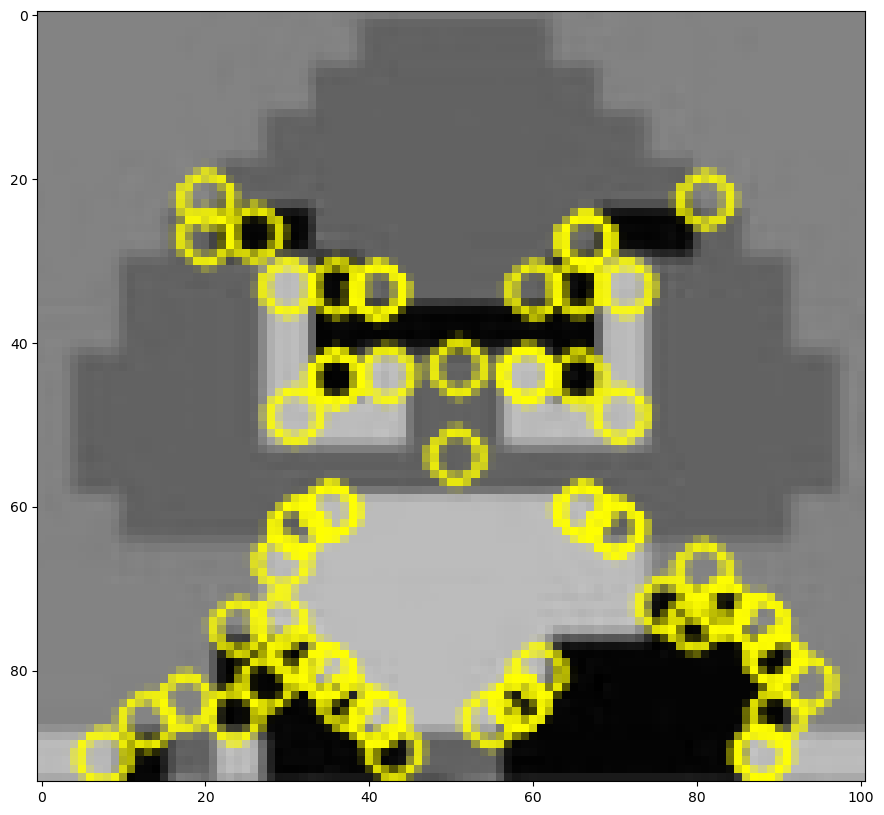

In [44]:
# Преобразуем и вносим небольшие изменения в шаблон

    # Преобразуем в оттенки серого
scale = 1.1 # масштаб изменения размеров
scBr = 0.9 # коэффициент изменения яркости

template_scale = cv2.resize(np.uint8(0.9*cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)),
           (int(template.shape[1]*scale), int(template.shape[0]*scale)), interpolation = cv2.INTER_AREA)

# Создаем детектор особых точек
sift = cv2.SIFT_create()
# sift = cv2.xfeatures2d.SIFT_create() # В зависимости от версии opencv может работать эта команда

# Запускаем детектор на изображении и на шаблоне
# Метод возвращает список особых точек и их дескрипторов
k_1, des_1 = sift.detectAndCompute(gray_img, None)
k_2, des_2 = sift.detectAndCompute(template_scale, None)

# Каждая особая точка имеет несколько параметров, таких как координаты, 
# размер, угол ориентации, мощность отклика и размер области особой точки.
print(k_1[1].pt)
print(k_1[1].size)
print(k_1[1].angle)
print(k_1[1].response)
print(k_1[1].size)

# Отрисуем найденные точки на картинке
image_key_point = cv2.drawKeypoints(gray_img, k_1, des_1, (0, 255, 255))
plt.figure()
plt.imshow(cv2.cvtColor(image_key_point, cv2.COLOR_BGR2RGB))

# Отрисуем найденные точки на шаблоне
template_key_point = cv2.drawKeypoints(template_scale, k_2, des_2, (0, 255, 255))
plt.figure()
plt.imshow(cv2.cvtColor(template_key_point, cv2.COLOR_BGR2RGB))

Найденные точки на шаблоне и изображении нужно сопоставить друг с другом по их совпадению мы поймем какая часть изображения соотносится с шаблоном для этого исмользуется объект BFMatcher, который в качестве параметров принимает метрику. По умолчанию используется метрика - cv2.NORM_L2 - среднеквадратичное расстояние или cv2.NORM_L1 - модуль разницы координат. Её можно использовать для детекторов SIFT и SURF. Для бинарных дескрипторов (в детекторах ORB, BRIEF, BRISK) используется расстояние Хэмминга cv2.NORM_HAMMING. Если ORB использует VTA_K == 3 или 4, следует использовать cv2.NORM_HAMMING2. Параметр crossCheck указывает что необходимо вернуть ровно одно совпадение для каждой особой точки

In [37]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)


 Дескрипторы используются для сопоставления особых точек шаблона и изображения между собой.
 На выходе получаем кортеж элементов DMatch 
 Каждый элемент содержит:
 - queryIdx - индекс особой точки на изображении, 
 - trainIdx - индекс особой точки шаблона, соответствующего этому совпадению,
 - distance -  расстояние между парой совпадающих особых точек,  чем меньше это значение, тем ближе находятся две точки. 

In [38]:
matches = bf.match(des_1, des_2)

print(matches[1].queryIdx)
print(matches[1].trainIdx)
print(matches[1].distance)


999
0
2143.0


Через индексы, содержащиеся в DMatch, можно обращаться к массиву особых точек.
Подставим индекс точки изображения из первого совпадения в массив ключевых точек и выведем ее размер.
Для того, чтобы отобрать наилучшие совпадения (пары совпадающих точек) отсортируем кортеж совпадений по расстоянию и построим эти совпадения на изображении количество совпадающих точек, котовые построятся на изображении указывается в matches[:10]

2.1094260215759277


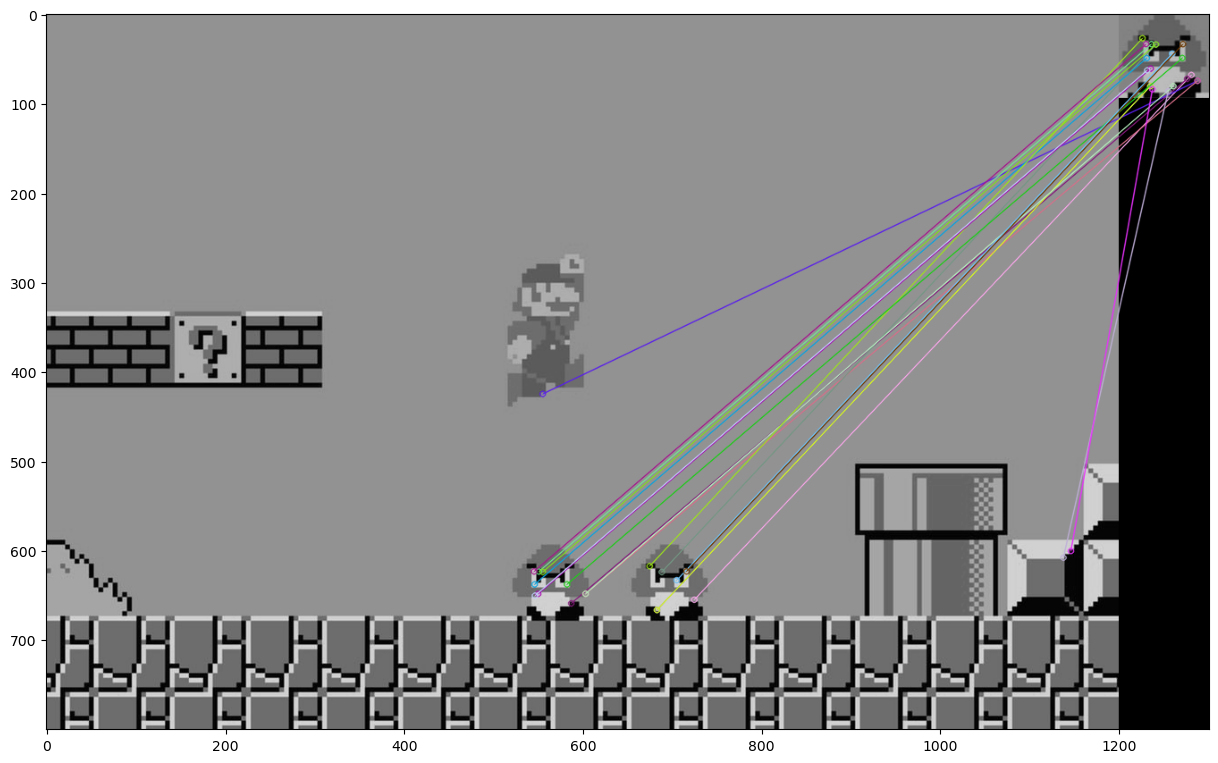

In [45]:
print(k_1[matches[1].queryIdx].size)
matches = sorted(matches, key=lambda x: x.distance)
image_with_matches = cv2.drawMatches(gray_img, k_1, template_scale, k_2, matches[:20], template_scale, flags=2)
plt.figure()
plt.imshow(cv2.cvtColor(image_with_matches, cv2.COLOR_BGR2RGB))

Для большей устойчивости определения соответствия точек может использоваться knnMatch, с параметром k, который определяет не только ближайшее совпадение для каждой точки шаблона, но и k ближайших.
Теперь кортеж DMatch будет многомерным (двумерным, если k=2),так как каждой точке шаблона соответствует несколько точек изображения.
Лучшие пары особых точек отбираются с использованием теста отношения правдоподобия

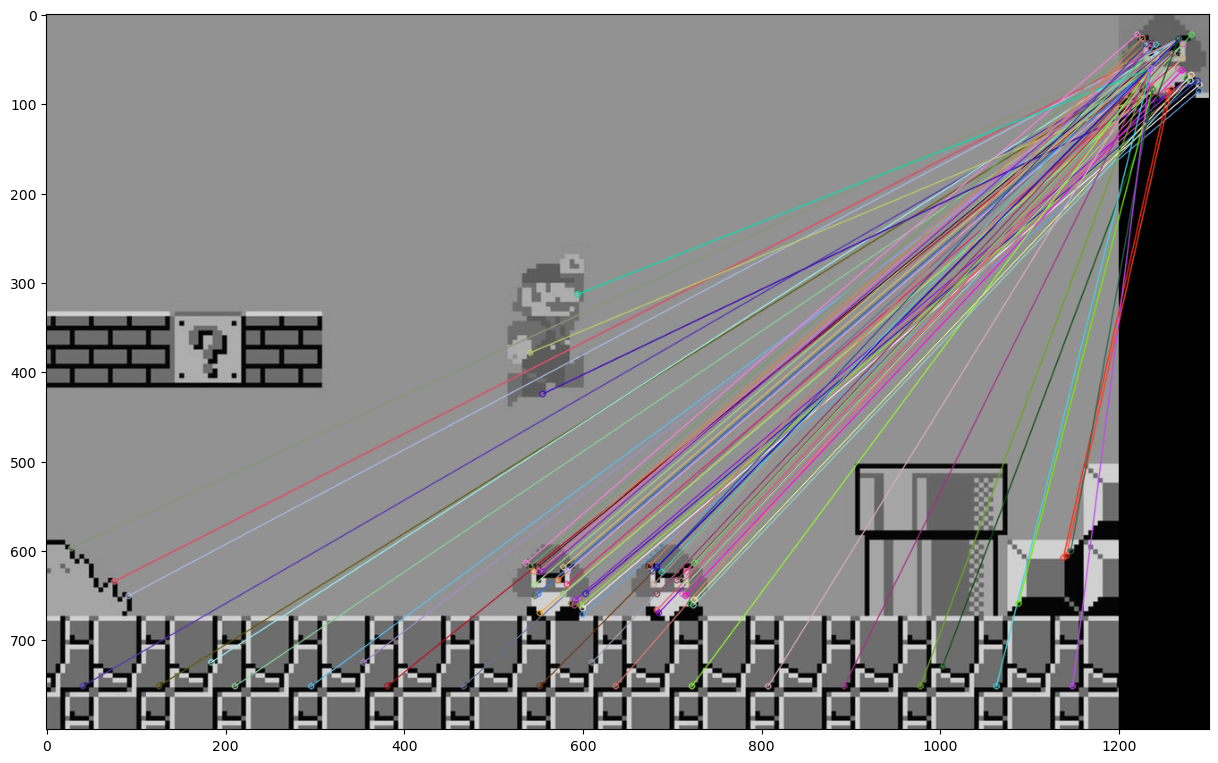

In [47]:
bf = cv2.BFMatcher(cv2.NORM_L1)
matches = bf.knnMatch(des_1, des_2, k=2)

# Лучшие пары особых точек отбираются с использованием теста отношения правдоподобия
good = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good.append([m])

# построим совпадения на изображении
image_with_knn_matches = cv2.drawMatchesKnn(gray_img,k_1,template_scale,k_2,good[:200],None,flags=2)
plt.figure()
plt.imshow(cv2.cvtColor(image_with_knn_matches, cv2.COLOR_BGR2RGB))


Для определения локализации объектов применим алгоритм кластеризации особых точек.
Идея состоит в том, что в области объекта концентрация особых точек будет выше.

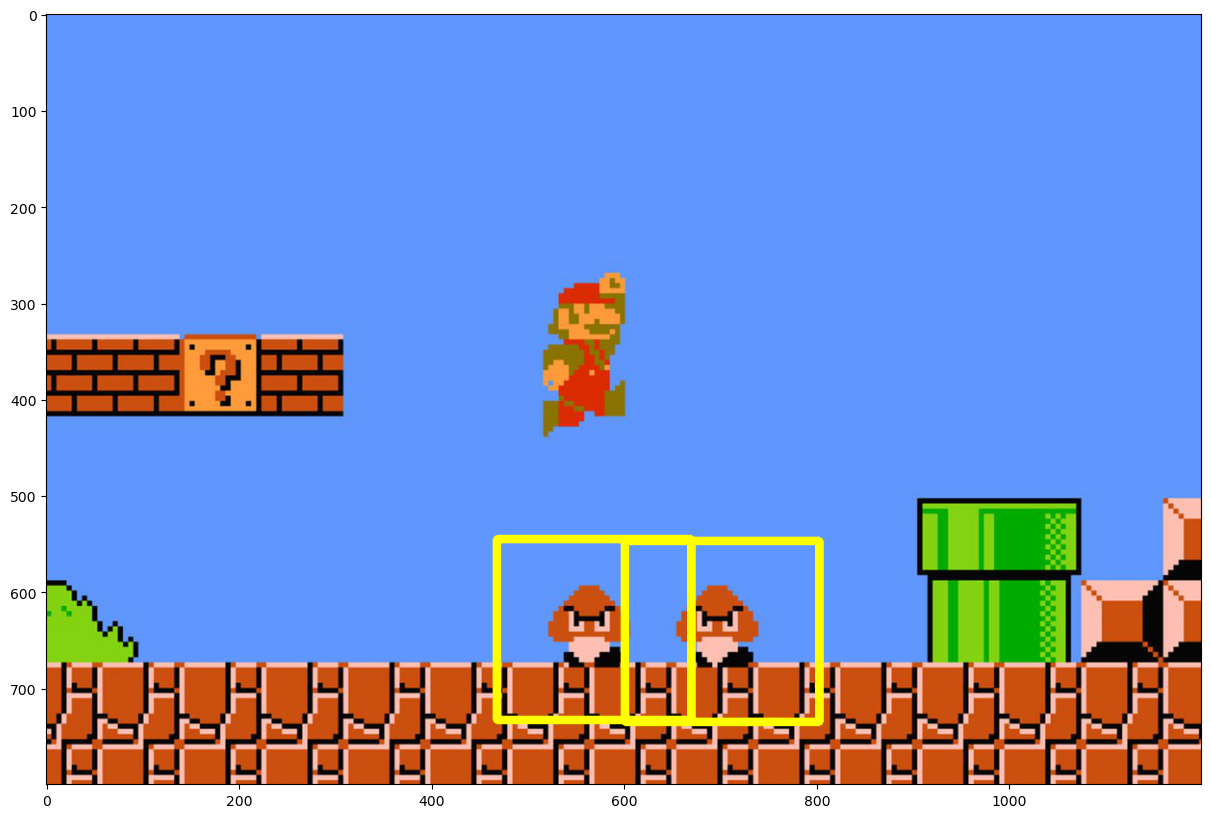

In [49]:
points = np.array([(0, 0)])
for i in good:
    points = np.append(points, [k_1[i[0].queryIdx].pt], axis=0)

points = points[1:len(points)]

# Определяем ширину окна и запускаем алгоритм кластеризации
bandwidth = estimate_bandwidth(points, quantile=0.1)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=False)
cl = ms.fit_predict(points)

# Формируем кластеры особых точек
labels_unique = np.unique(ms.labels_)
kp = []
for i in labels_unique:
    kp.append(points[cl==i])

# Определяем центры кластеров, но только если в кластере содержится более 10 точек
cen = []
for i in kp:
    if len(i)>10:
        cen.append(np.mean(i, axis=0).astype(np.uint16))

# Вокруг выделенных центров обводим прямоугольники с размерами шаблона
plot_img = rgb_img.copy()
h, w = template_scale.shape

for pt in cen:
    cv2.rectangle(plot_img, (pt[0] - w, pt[1] - h),(pt[0] + w, pt[1] + h),(0,255,255), 8)  

# Отображаем результат на графике
plt.figure()
plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))

### Задание: придумайте и реализуйте алгоритм сопоставления шаблонов для изображений, где объекты повернуты и разных размеров. Например, для изображения ниже. Или изображения выданного преподавателем. 

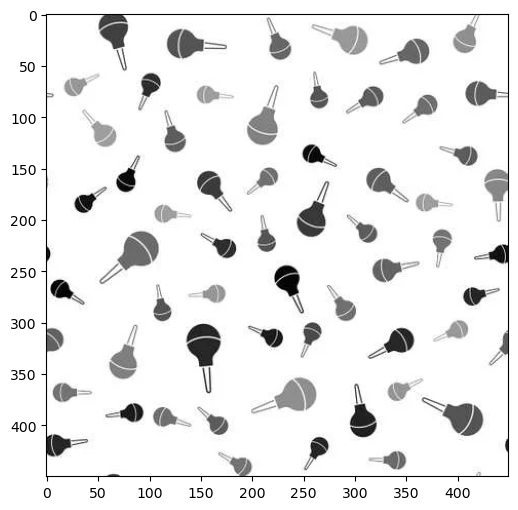

In [51]:
bgr_image = cv2.imread('../images/pear.png')
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(rgb_image)


# 2. Локальные особенности. Особые точки.

Локальные особенности изображения - это хорошо различимые фрагменты объектов на изображении. Как правило, речь идет о поиске точек, каждая из которых обладает характерной окрестностью, отличающую эту точку от остальных.
 В разной литературе точки с локальными особенностями называют особыми точками (feature points или просто features), локальными особыми точками (local feature points) или характеристическими точками (characteristic points).

При поиске особых точек, к ним предъявляются следующие требования:
- повторимость, т.е. находились всегда в том же месте несмотря на изменения масшаба, положения, ракурса и освещения;
- локальность. Особые точки должны определяться маленькой окрестностью, чтобы работа с ней не была чувствительна к перекрытиям;
- значимость. Каждая точька должна иметь уникальное описание;
- компактность и эффективность. Количество особых точек, должно быть значительно меньше пикселей изображения.

Особые точки используются в задачах поиска и выделения объектов на изображениях, распознавания объектов на изображениях, для поиска изображений в базе данных или в файловой системе, сопоставления изображений, например, для построения карты местности.

Алгоритмы поиска особых точек называются детекторами. Рассмотрим некоторые из них.

## 2.1 Детектор Харриса

Детектор Харриса - один из первых и самых популярных детекторов особых точек. Ищет такие точки, окрестность которых меняется при любом сдвиге. При создании этого детектора авторами (Крисом Харрисом и Майком Стивенсом) было предложено в качестве особых точек искать углы. и  Такими точками в Харрис и  предлагаются искать углы.

Подробное описание алгоритма и пример его работы можно посмотреть на сайте [OpenCV](https://docs.opencv.org/4.5.5/dc/d0d/tutorial_py_features_harris.html)



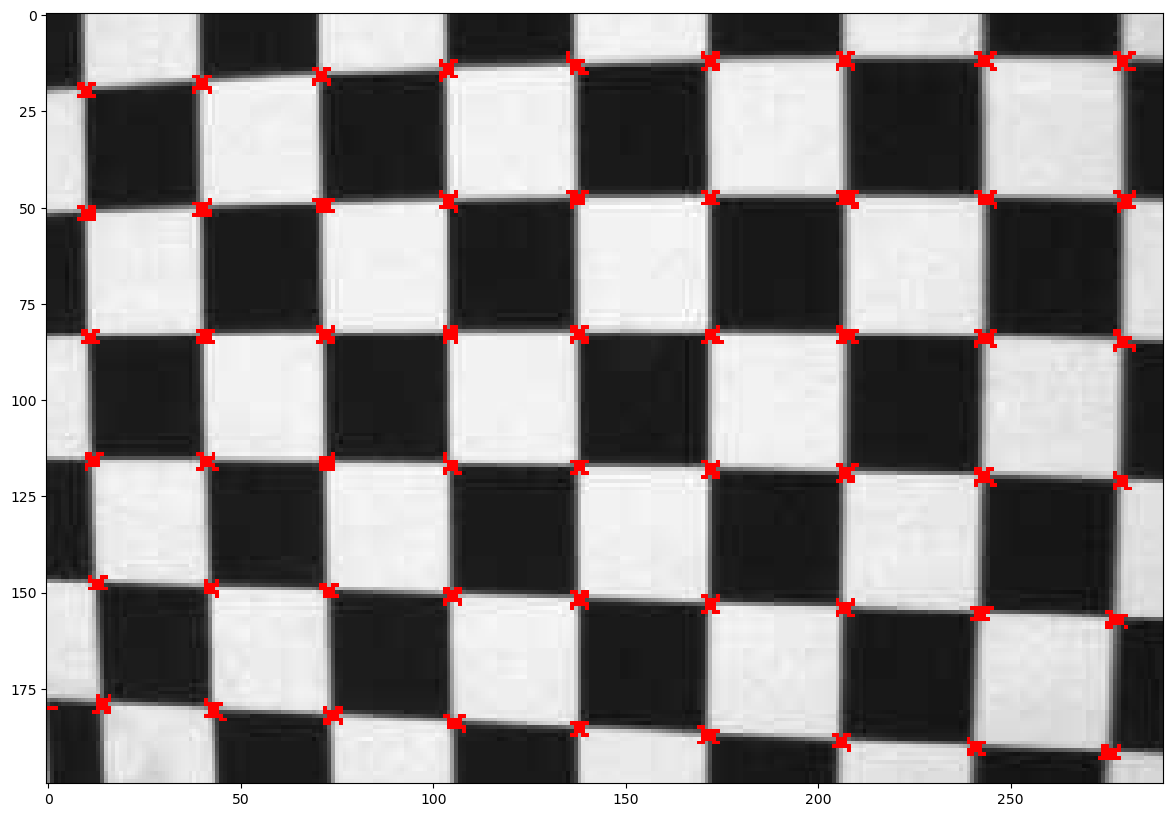

In [53]:
rgb_image = cv2.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)

cropped_image = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

gray_image = np.float32(gray_image)
dst = cv2.cornerHarris(gray_image, 2, 3, 0.04)
# Threshold for an optimal value, it may vary depending on the image.
cropped_image[dst > 0.01 * dst.max()] = [255, 0, 0]
plt.imshow(cropped_image)

Если стоит задача поиска углов с субпиксельной точностью, можно использовать функцию cv.cornerSubPix(), которая дополнительно уточняет обнаруженные углы с точностью до субпикселя.

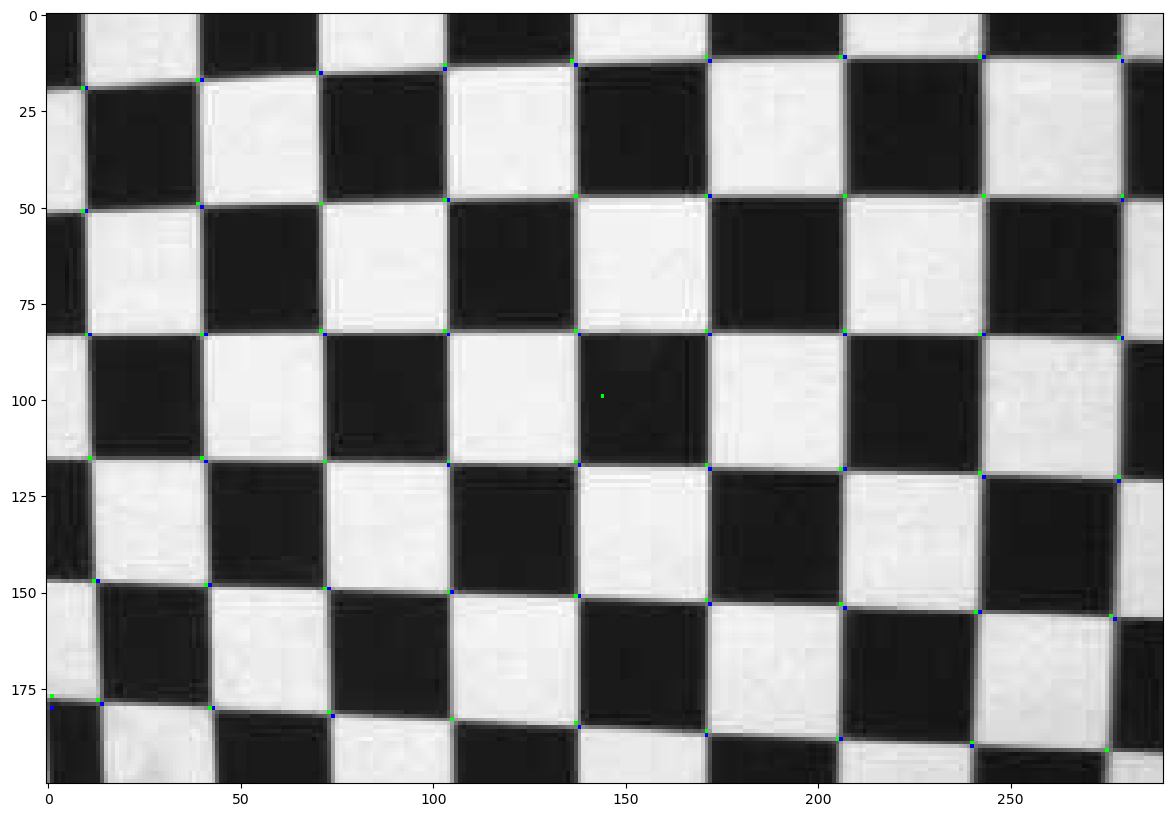

In [56]:
rgb_image = cv2.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
image = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# find Harris corners
gray_image = np.float32(gray_image)
dst = cv2.cornerHarris(gray_image, 2, 3, 0.04)
dst = cv2.dilate(dst, None)
ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
dst = np.uint8(dst)
# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray_image, np.float32(centroids), (5, 5), (-1, -1), criteria)
# Now draw them
res = np.hstack((centroids, corners))
res = np.int0(res)
image[res[:, 1], res[:, 0]] = [0, 0, 255]
image[res[:, 3], res[:, 2]] = [0, 255, 0]
plt.imshow(image)

Чтобы увидеть результат, нужно приблизить получившееся изображение. Должно получиться как на рисунке:
<img height="100" src="../content/subpixel_corner_detection.png"/>

## 2.2 Детектор Shi-Tomasi
Детектор Shi-Tomasi является усовершенствованным вариантом детектора Харриса.
Для нахождения особых точек методом Shi-Tomasi в OpenCV есть функция goodFeaturesToTrack(). Она находит N сильнейших углов на изображении. В качестве параметров функции передается: желаемое число углов, которое нужно найти; число от 0 до 1, определяющее уровень "качества" углов, ниже которого найденые углы отсекаются; минимальное евклидово расстояние между найденными углами.
Подробнее про функцию [goodFeaturesToTrack()](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)

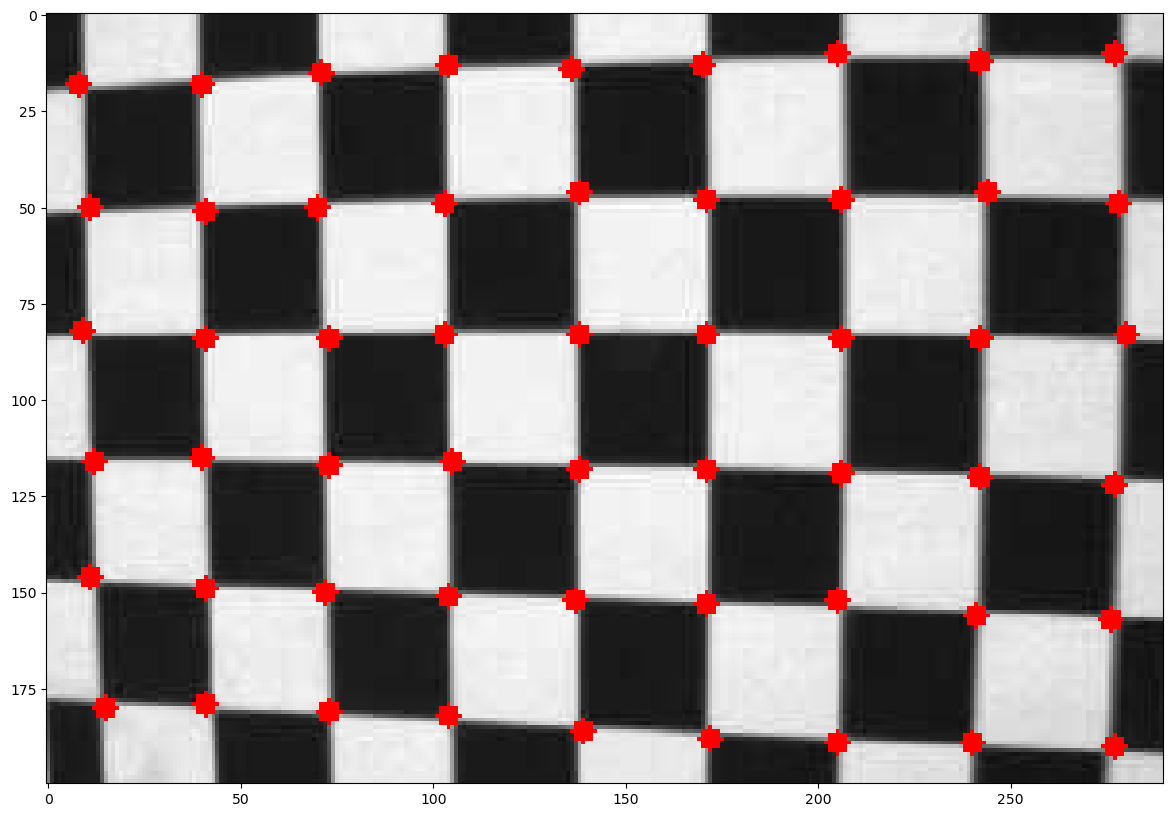

(<matplotlib.image.AxesImage at 0x7f3def2d4810>, None)

In [57]:
rgb_image = cv2.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
image = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray_image, 54, 0.01, 10)
corners = np.int0(corners)
for i in corners:
    x, y = i.ravel()
    cv2.circle(image, (x, y), 3, 255, -1)

plt.imshow(image), plt.show()

##  2.3 SIFT (Scale-Invariant Feature Transform)

SIFT -- это детектор инвариантный (нечувствительный) к масштабированию. Как известно, рассмотренные выше детекторы особых точек инвариантны к повороту изображения благодаря тому, что они обнаруживают углы. Но углы в одном масштабе могут не являться углами в другом масштабе.
<img height="100" src="../content/corners_example.png"/>
В отличии от детектора Харриса, SIFT является инвариантным к масштабированию. А в качестве особых точек ищет не углы, а иные точки изображения инвариантные к повороту, смещению, масштабированию, изменению освещенности и частично к аффинным преобразованиям.
Подробнее в статье на сайте [OpenCV](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html).

Рассмотрим применение SIFT с использованием OpenCV.


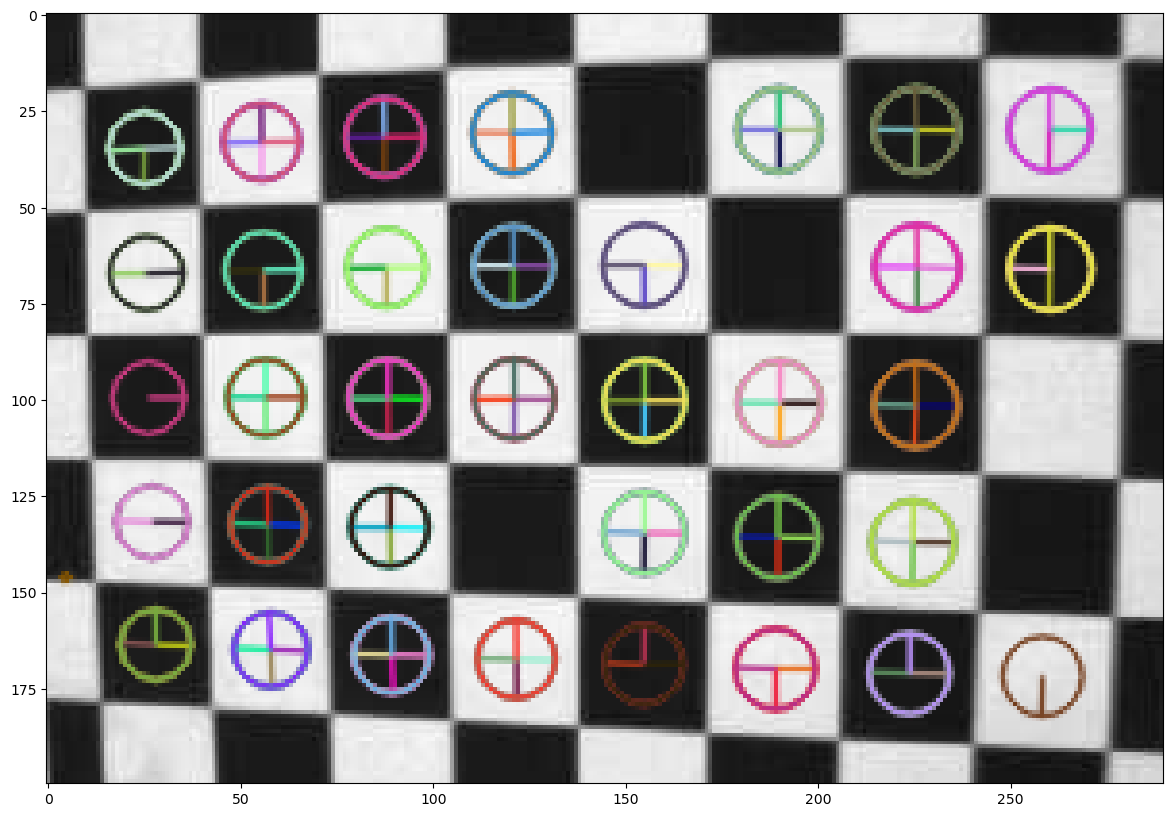

In [58]:
rgb_image = cv2.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
image = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp = sift.detect(gray_image, None)
image = cv2.drawKeypoints(gray_image, kp, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(image)

## 2.4 FAST
Рассмотренные выше алгоритмы поиска особых точек на изображениях достаточно эффективны, но вычислительно сложные. Они не позволяют использовать их в приложениях реального времени на устройствах с ограниченными вычислительными ресурсами.

Для решения этой проблемы был предложен алгоритм [FAST](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html).

Применение детектора FAST с использованием OpenCV представлен ниже.

Threshold: 10
nonmaxSuppression:True
neighborhood: 2
Total Keypoints with nonmaxSuppression: 282


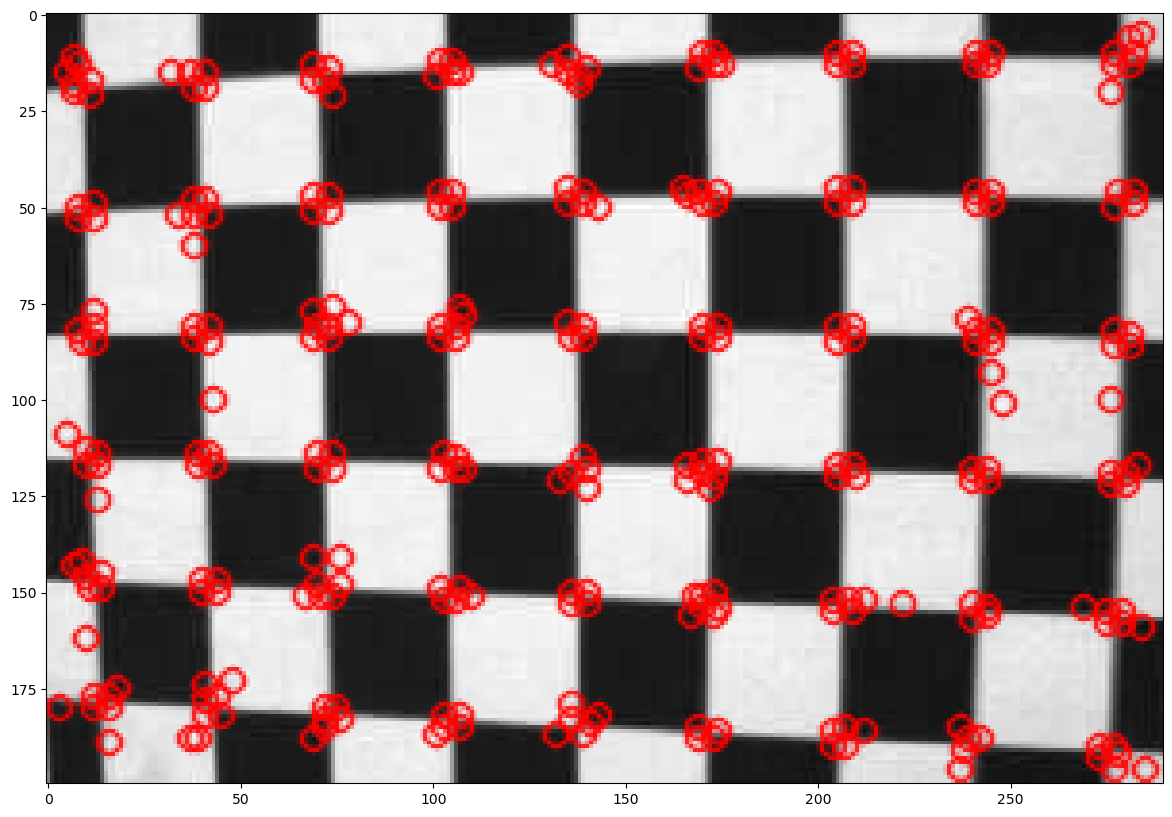

In [60]:
rgb_image = cv2.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
img = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()
# find and draw the keypoints
kp = fast.detect(img,None)
img2 = cv2.drawKeypoints(img, kp, None, color=(255,0,0))
# Print all default params
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
cv2.imwrite('fast_true.png', img2)
plt.imshow(img2)

### Задание. Напишите алгоритм удаляющий близкорасположенные точки для кода выше.

## 2.5 ORB (Oriented FAST and Rotated BRIEF)

[ORB](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html) - это быстрый и надежный детектор особых точек, представленный в 2011 году. Он основан на детекторе FAST и модифицированном детектора BRIEF. Целью его создания было предоставление бесплатного детектора для замены запатентованного детектора SIFT, использование которого в коммерческих целях требовало лицензионных отчислений автору.

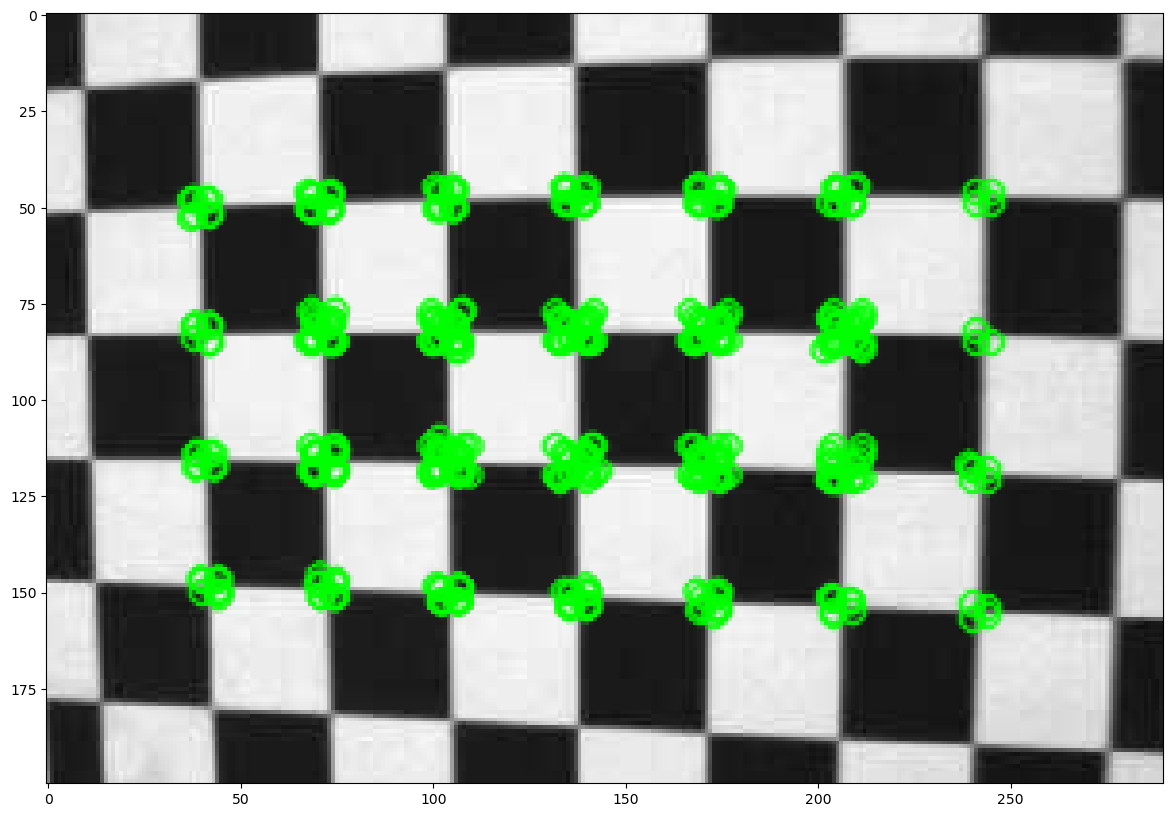

(<matplotlib.image.AxesImage at 0x7f3def10bbd0>, None)

In [62]:
rgb_image = cv2.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
img = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()